# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


In [2]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

![title](D:\GoogleDrive\retina\Chou's data\20210504\FIG\cSTA\fitNGD2Lparameter.tiff)

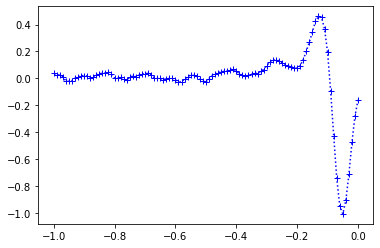

In [3]:
fig, ax = plt.subplots()
dt = 0.01
x_list, T_list, rstate_list = expSnR(['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_cSTA_sort_unit2.mat']
                                     , dt, 'LED', np.arange(60)+1)
x = x_list[0]
x = x-np.mean(x)
cn = 53-1
rstate = rstate_list[0][cn,:]
cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
ax.plot(taxis, cSTA, 'b+:')

# NGD1L

In [4]:
def NGD_TK(T, alpha, beta, g,  tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = 0.1*dt
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + -x[j]-z[j] )
        dz=dt*(-beta *z[j]  + g*y[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
#     print(len(w), len(w[::10]))
    return Amp*y[::10]/(dt) #normalized by integration

In [5]:
def NGD_TK_AS(T, tau, omegastar, deltastar, tau_y, Bmp):
    dt = np.mean(np.diff(T))
    dt = 0.1*dt
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = -Bmp*np.exp(-T/tau)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):10]

alpha: 29.720752078374467
beta : 0.8985577712627879
g    : 2161.968546114135
tau_y: 0.0703792898689763
Amp  : 17.223775670410063


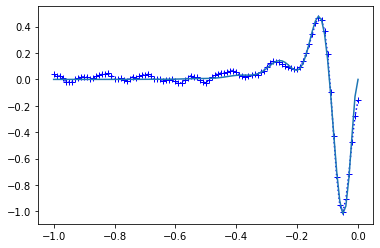

In [6]:
alpha, beta = 14.,1.2
g = 680.
tau_y = 0.03
Amp = 4
popt,pcov = curve_fit(NGD_TK, np.abs(taxis) , cSTA, p0=[alpha, beta, g,  tau_y, Amp],
                      bounds = ([0     , 0     , 0     , 0     , 0     ],
                                [np.inf, np.inf, np.inf, 0.6   , np.inf]) )
[alpha, beta, g,  tau_y, Amp] = popt
print('alpha:',alpha)
print('beta :',beta)
print('g    :',g)
print('tau_y:',tau_y)
print('Amp  :',Amp)
fit_cSTA = NGD_TK(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig

## Parameter Transfer

In [7]:
print('alpha:',alpha)
print('beta :',beta)
print('g    :',g)
print('tau_y:',tau_y)
print('Amp  :',Amp)
tau = 2/(alpha+beta)
omegastar = np.sqrt(4*g-(alpha-beta)**2)/2
deltastar = np.arctan((alpha-beta)/np.sqrt(4*g-(alpha-beta)**2))
Bmp = Amp*np.sqrt(4*g)/np.sqrt(4*g-(alpha-beta)**2) #=A/np.cos(deltastar)
print('\n')
print('alpha:',1/tau+omegastar*np.tan(deltastar))
print('beta :',1/tau-omegastar*np.tan(deltastar))
print('g    :',omegastar**2*(1+np.tan(deltastar)**2))
print('tau_y:',tau_y)
print('Amp  :',Bmp*np.cos(deltastar))

alpha: 29.720752078374467
beta : 0.8985577712627879
g    : 2161.968546114135
tau_y: 0.0703792898689763
Amp  : 17.223775670410063


alpha: 29.72075207837446
beta : 0.898557771262789
g    : 2161.9685461141344
tau_y: 0.0703792898689763
Amp  : 17.223775670410063


tau      : 0.06531825863552879
omegastar: 44.20733903940509
deltastar: 0.3151259696234272
tau_y    : 0.0703792898689763
Bmp      : 18.11584815074542


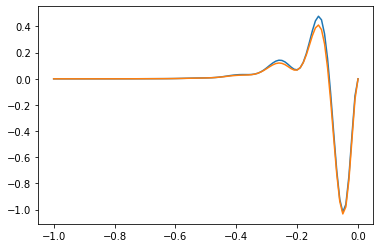

In [8]:
plt.plot(taxis, fit_cSTA)
test_cSTA = NGD_TK_AS(np.abs(taxis), tau, omegastar, deltastar, tau_y, Bmp)
plt.plot(taxis, test_cSTA)
print('tau      :',2/(alpha+beta))
print('omegastar:',np.sqrt(4*g-(alpha-beta)**2)/2)
print('deltastar:',np.arctan((alpha-beta)/np.sqrt(4*g-(alpha-beta)**2)))
print('tau_y    :',tau_y)
print('Bmp      :',Amp*np.sqrt(4*g)/np.sqrt(4*g-(alpha-beta)**2))

tau      : 0.07178929872142926
omegastar: 44.48571100175153
deltastar: 0.3075910703959358
tau_y    : 0.07201062642778806
Bmp      : 18.142148853401704


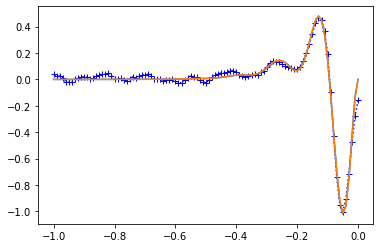

In [9]:
tau  = 1/10
omegastar= 32
deltastar= 0.
tau_y    = 0.06
Bmp      = 17

popt,pcov = curve_fit(NGD_TK_AS, np.abs(taxis) , cSTA, p0=[tau, omegastar, deltastar, tau_y, Bmp],
                      bounds = ([0     , 0     , 0     , 0     , 0     ],
                                [np.inf, np.inf, np.inf, 0.6   , np.inf]) )
[tau, omegastar, deltastar, tau_y, Bmp] = popt
print('tau      :',tau)
print('omegastar:',omegastar)
print('deltastar:',deltastar)
print('tau_y    :',tau_y)
print('Bmp      :',Bmp)
fit_cSTA = NGD_TK_AS(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig

# NGD2L_FBFF 

In [10]:
def NGD2L_TK(T, alpha, beta, gamma, g, h, tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + x[j]-z[j] )
        dz=dt*(-beta *z[j] + g*y[j] )
        dw=dt*(-gamma*w[j] + y[j]-h*z[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        w[j+1]=w[j]+dw
#     print(len(w), len(w[::10]))
    return -Amp*w[::50]/(dt)#normalized by integration

In [11]:
def NGD2L_TK_AS(T, tau, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-T/tau)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

In [12]:
alpha, beta = 14.,14.
gamma = 36.
g = 680.
h = 0.01
tau_y = 0.027
Amp = 100
popt,pcov = curve_fit(NGD2L_TK, np.abs(taxis) , cSTA, p0=[alpha, beta, gamma, g, h, tau_y, Amp],
                      bounds = ([0     , 0     , 0     , 0     , 0     , 0     , 0     ],
                                [np.inf, np.inf, np.inf, np.inf, np.inf, 0.6   , np.inf]) )
[alpha, beta, gamma, g, h, tau_y, Amp] = popt
print('alpha :',alpha)
print('beta  :',beta)
print('gamma :',gamma)
print('g     :',g)
print('h     :',h)
print('tau_y :',tau_y)
print('Amp   :',Amp)
fit_cSTA = NGD2L_TK(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

## Parameter Transfer

In [ ]:
plt.plot(taxis, fit_cSTA)
tau = 2/(alpha+beta)
omegastar = np.sqrt(4*g-(alpha-beta)**2)/2
deltastar = np.arctan( (beta**2-2*g-alpha*beta+alpha*gamma-beta*gamma-alpha*g*h-beta*g*h+2*gamma*g*h)
                      /(np.sqrt(4*g-(alpha-beta)**2)*(-beta+gamma+g*h)) )
Dmp = -Amp*(beta-gamma-g*h)/(g+alpha*beta-alpha*gamma-beta*gamma+gamma**2)
test_cSTA = NGD2L_TK_AS(np.abs(taxis), tau, gamma, omegastar, deltastar, tau_y, Dmp)
plt.plot(taxis, test_cSTA)
print('tau      :',tau)
print('gamma    :',gamma)
print('omegastar:',omegastar)
print('deltastar:',deltastar)
print('tau_y    :',tau_y)
# print('Bmp      :',Bmp)
print('Dmp      :',Dmp)

In [ ]:
plt.plot(taxis, fit_cSTA)
alpha = 1/tau
beta = 1/tau
g = omegastar**2
h = ( (-1/tau+gamma)*omegastar*np.tan(deltastar)+omegastar**2 )/( omegastar**2*(-1/tau+gamma-omegastar*np.tan(deltastar)) )
Amp = Dmp*(g+alpha**2-2*alpha*gamma+gamma**2)/(-alpha+gamma+g*h)
newfit_cSTA = NGD2L_TK(np.abs(taxis), alpha, beta, gamma, g, h, tau_y, Amp)
plt.plot(taxis, newfit_cSTA)

In [ ]:
# tau = 2/(alpha+beta)
# omegastar = np.sqrt(4*g-(alpha-beta)**2)/2
# deltastar = 0
# Bmp = 20
# Dmp = 1
popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis) , cSTA, p0=[tau, gamma, omegastar, deltastar, tau_y,  Dmp],
                      bounds = ([0     , 0     , 0     ,-np.pi, 0     , 0     ],
                                [np.inf, np.inf, np.inf, np.pi, 0.6   , np.inf]) )
[tau, gamma, omegastar, deltastar, tau_y,  Dmp] = popt
print('tau      :',tau)
print('gamma    :',gamma)
print('omegastar:',omegastar)
print('deltastar:',deltastar)
print('tau_y    :',tau_y)
print('Dmp      :',Dmp)
fit_cSTA = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
ax.plot(taxis, fit_cSTA)
fig

In [ ]:
np.cos(deltastar)